# Example used in the blog (Physics & Computer, Love.) article:

## *Clustering particle collisions with Quadtree*

Read more about: https://physicscomputerlove.com/en/data-structure/quadtree


## Load the detected particle collisions
---

### Download the dataset

In [1]:
import requests
import tarfile
import os
import sys

__file__ = os.path.abspath('GroupingDetectedParticleCollisions.ipynb')
sys.path.append(os.path.abspath(os.path.join(os.path.dirname(__file__), '..', 'src')))

dataset_url = 'https://zenodo.org/records/14386134/files/trackml_40k-events-10-to-50-tracks.tar.gz?download=1'
local_tar_path = 'datasets/trackml_40k-events-10-to-50-tracks.tar.gz'
local_extract_path = 'datasets/trackml_40k-events-10-to-50-tracks'

if not os.path.exists('datasets'):
    os.makedirs('datasets')

if not os.path.exists(local_tar_path):
    print('Downloading dataset...')
    with open(local_tar_path, 'wb') as f:
        response = requests.get(dataset_url, stream=True)
        for data in response.iter_content(chunk_size=1024):
            if data:
                f.write(data)

    print('Extracting dataset...')
    with tarfile.open(local_tar_path) as tar:
        tar.extractall(local_extract_path)

print('Dataset ready!')

Dataset ready!


### Load the dataset

In [2]:
import pandas as pd
from IPython.display import display

path = 'datasets/trackml_40k-events-10-to-50-tracks/trackml_40k-events-10-to-50-tracks.csv'
df_collisions = pd.read_csv(path)[['x', 'y', 'q', 'particle_id']]
display(df_collisions.head(10))

print(f'Total of detected particle collisions: {len(df_collisions)}')

,x,y,q,particle_id
0,-57.4190,-67.1905,1,4504974016905216
1,-49.4727,-58.4256,1,4504974016905216
2,-41.6409,-49.6406,1,4504974016905216
3,-36.2328,-43.3855,1,4504974016905216
4,-36.4109,-43.5820,1,4504974016905216
5,-31.0184,-37.3745,1,4504974016905216
6,-30.8612,-37.1731,1,4504974016905216
7,-30.9992,-37.3324,1,4504974016905216
8,-26.4289,-32.0082,1,4504974016905216
9,-26.2202,-31.8162,1,4504974016905216


Total of detected particle collisions: 9949945


## Extract and view samples for analysis
---

In [3]:
from helper import visualize_samples

df_samples = df_collisions[0:2000]
display(df_samples.head(10))

,x,y,q,particle_id
0,-57.4190,-67.1905,1,4504974016905216
1,-49.4727,-58.4256,1,4504974016905216
2,-41.6409,-49.6406,1,4504974016905216
3,-36.2328,-43.3855,1,4504974016905216
4,-36.4109,-43.5820,1,4504974016905216
5,-31.0184,-37.3745,1,4504974016905216
6,-30.8612,-37.1731,1,4504974016905216
7,-30.9992,-37.3324,1,4504974016905216
8,-26.4289,-32.0082,1,4504974016905216
9,-26.2202,-31.8162,1,4504974016905216


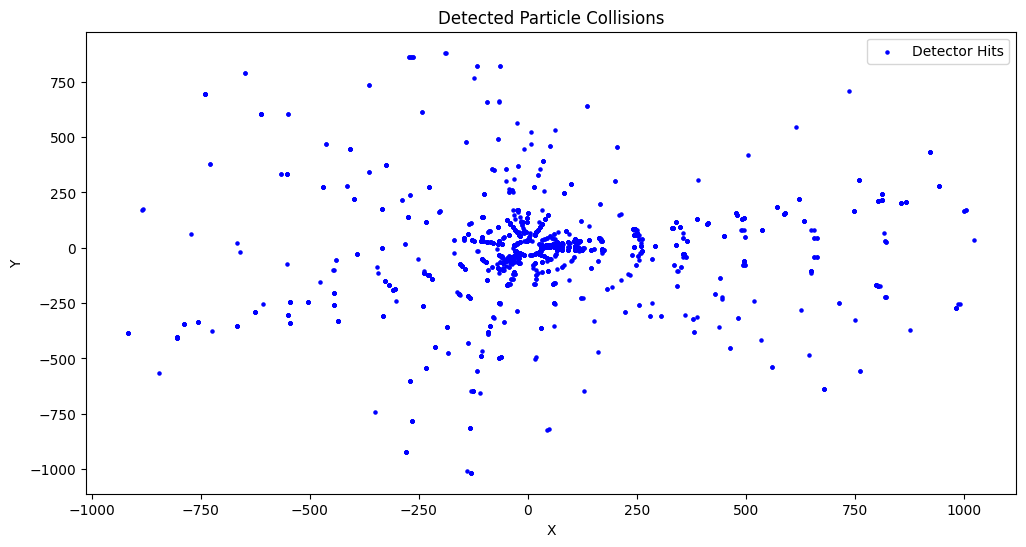

In [4]:
visualize_samples(df_samples)

## Create clusters from detected particle collisions
---

### Create two-dimensional space

In [5]:
from dataclasses import dataclass
@dataclass(slots=True)
class Point:
    x: int
    y: int
    metadata: dict = None

    def __repr__(self):
        return f'Point({self.x}, {self.y})'

points = [Point(row.x, row.y, metadata=row.to_dict()) for index, row in df_samples.iterrows()]
points[:10]

[Point(-57.419, -67.1905),
 Point(-49.4727, -58.4256),
 Point(-41.6409, -49.6406),
 Point(-36.2328, -43.3855),
 Point(-36.4109, -43.582),
 Point(-31.0184, -37.3745),
 Point(-30.8612, -37.1731),
 Point(-30.9992, -37.3324),
 Point(-26.4289, -32.0082),
 Point(-26.2202, -31.8162)]

In [6]:
@dataclass(slots=True)
class Rectangle:
    x: int
    y: int
    width: int
    height: int

    def contains(self, point):
        return (self.x <= point.x < self.x + self.width and
                self.y <= point.y < self.y + self.height)

    def intersects(self, other) -> bool:
        return not (other.x > self.x + self.width or
                other.x + other.width < self.x or
                other.y > self.y + self.height or
                other.y + other.height < self.y)

    def __repr__(self):
        return f'Rectangle({self.x}, {self.y}, {self.width}, {self.height})'

In [7]:
def compute_bounding_box(points: list) -> Rectangle:
    min_x = min(p.x for p in points)
    max_x = max(p.x for p in points)
    min_y = min(p.y for p in points)
    max_y = max(p.y for p in points)
    return Rectangle(min_x, min_y, max_x - min_x, max_y - min_y)

In [8]:
boundary = compute_bounding_box(points)
boundary

Rectangle(-916.693, -1016.22, 1939.953, 1897.181)

### Quadtree Implementation

In [9]:
import numpy as np
import matplotlib.pyplot as plt


class Quadtree:
    def __init__(self, boundary: Rectangle, capacity):
        self.boundary = boundary
        self._capacity = capacity
        self.points = np.empty((capacity, 2), dtype=np.int32)
        self._metadata = np.empty(capacity, dtype=object)
        self._point_count = 0
        self._divided = False

        self._north_east = None
        self._north_west = None
        self._south_east = None
        self._south_west = None

    def subdivide(self):
        x = self.boundary.x
        y = self.boundary.y
        w = self.boundary.width
        h = self.boundary.height

        half_width = w // 2
        half_height = h // 2

        # Create four children that divide the current region
        nw = Rectangle(x, y, half_width, half_height)
        self._north_west = Quadtree(nw, self._capacity)

        ne = Rectangle(x + half_width, y - half_height, half_width, half_height)
        self._north_east = Quadtree(ne, self._capacity)

        sw = Rectangle(x, y + half_height, half_width, half_height)
        self._south_west = Quadtree(sw, self._capacity)

        se = Rectangle(x + half_width, y + half_height, half_width, half_height)
        self._south_east = Quadtree(se, self._capacity)

        # Mark the current region as divided
        self._divided = True

    def insert(self, point: Point):
        if not self.boundary.contains(point):
            return False # Point is not in the boundary

        # If there is space in the current region
        if self._point_count < self._capacity: #
            self.points[self._point_count] = (point.x, point.y)
            self._metadata[self._point_count] = point.metadata
            self._point_count += 1
            return True

        # If there is no space and the region is not divided
        if not self._divided:
            self.subdivide() # Subdivide the region if it hasn't been divided yet

        # Try to insert the point into the children regions
        return (self._north_west.insert(point) or
                self._north_east.insert(point) or
                self._south_west.insert(point) or
                self._south_east.insert(point))

    def insert_batch(self, points: list):
        for point in points:
            self.insert(point)

    def query(self, boundary: Rectangle, found=None):
        if found is None:
            found = []

        # Return if the range does not intersect the boundary
        if not self.boundary.intersects(boundary):
            return found

        for i in range(self._point_count):
            point = Point(*self.points[i], metadata=self._metadata[i])
            if boundary.contains(point):
                found.append(point)

        if self._divided:
            self._north_west.query(boundary, found)
            self._north_east.query(boundary, found)
            self._south_west.query(boundary, found)
            self._south_east.query(boundary, found)

        return found

    def plot(self, ax):
        rect = plt.Rectangle((self.boundary.x, self.boundary.y),
                             self.boundary.width,
                             self.boundary.height,
                             fill=False, color="black", lw=0.8)

        ax.add_patch(rect)

        if self._divided:
            for quadrant in [self._north_east, self._north_west, self._south_east, self._south_west]:
                quadrant.plot(ax)

## Analyze particle collisions
---

### 5.1. Insert points into the Quadtree

In [10]:
quadtree = Quadtree(boundary, capacity=10)
quadtree.insert_batch(points)

#### How to analyze regions automatically?


In [11]:
class SlidingWindowQuery:
    def __init__(self, quadtree: Quadtree):
        self._quadtree = quadtree

    def query(self, **kwargs):
        window_size = kwargs.get('window_size', 10)
        step_size = kwargs.get('step_size', window_size / 2)
        density_threshold = kwargs.get('density_threshold', 3)

        found = []
        boundary = self._quadtree.boundary

        x_start, y_start = boundary.x, boundary.y
        x_end, y_end = boundary.x + boundary.width, boundary.y + boundary.height

        x_values = np.arange(x_start, x_end - window_size + step_size, step_size)
        y_values = np.arange(y_start, y_end - window_size + step_size, step_size)

        for x in x_values:
            for y in y_values:
                window = Rectangle(x, y, window_size, window_size)
                points = self._quadtree.query(window)
                if len(points) >= density_threshold:
                    found.append((window, len(points), points))

        return found

In [12]:
window_size = 100 # Size of the window to analyze
step_size = 25 # Step size to slide the window
density_threshold = 20 # Minimum number of collisions in the window

sliding_window_query = SlidingWindowQuery(quadtree)
query_result = sliding_window_query.query(window_size=window_size,
                                          step_size=step_size,
                                          density_threshold=density_threshold)
display(query_result[:10])
%time

[(Rectangle(-841.693, -416.22, 100, 100),
  20,
  [Point(-788, -343),
   Point(-757, -336),
   Point(-804, -405),
   Point(-804, -405),
   Point(-788, -343),
   Point(-757, -336),
   Point(-804, -405),
   Point(-804, -405),
   Point(-788, -343),
   Point(-757, -336),
   Point(-804, -405),
   Point(-804, -405),
   Point(-804, -405),
   Point(-804, -405),
   Point(-804, -405),
   Point(-804, -405),
   Point(-788, -343),
   Point(-757, -336),
   Point(-788, -343),
   Point(-757, -336)]),
 (Rectangle(-816.693, -416.22, 100, 100),
  21,
  [Point(-788, -343),
   Point(-757, -336),
   Point(-804, -405),
   Point(-804, -405),
   Point(-788, -343),
   Point(-757, -336),
   Point(-804, -405),
   Point(-804, -405),
   Point(-788, -343),
   Point(-757, -336),
   Point(-804, -405),
   Point(-804, -405),
   Point(-804, -405),
   Point(-804, -405),
   Point(-804, -405),
   Point(-804, -405),
   Point(-788, -343),
   Point(-757, -336),
   Point(-788, -343),
   Point(-757, -336),
   Point(-725, -374)])

CPU times: user 1 μs, sys: 0 ns, total: 1 μs
Wall time: 2.62 μs


## View results
---

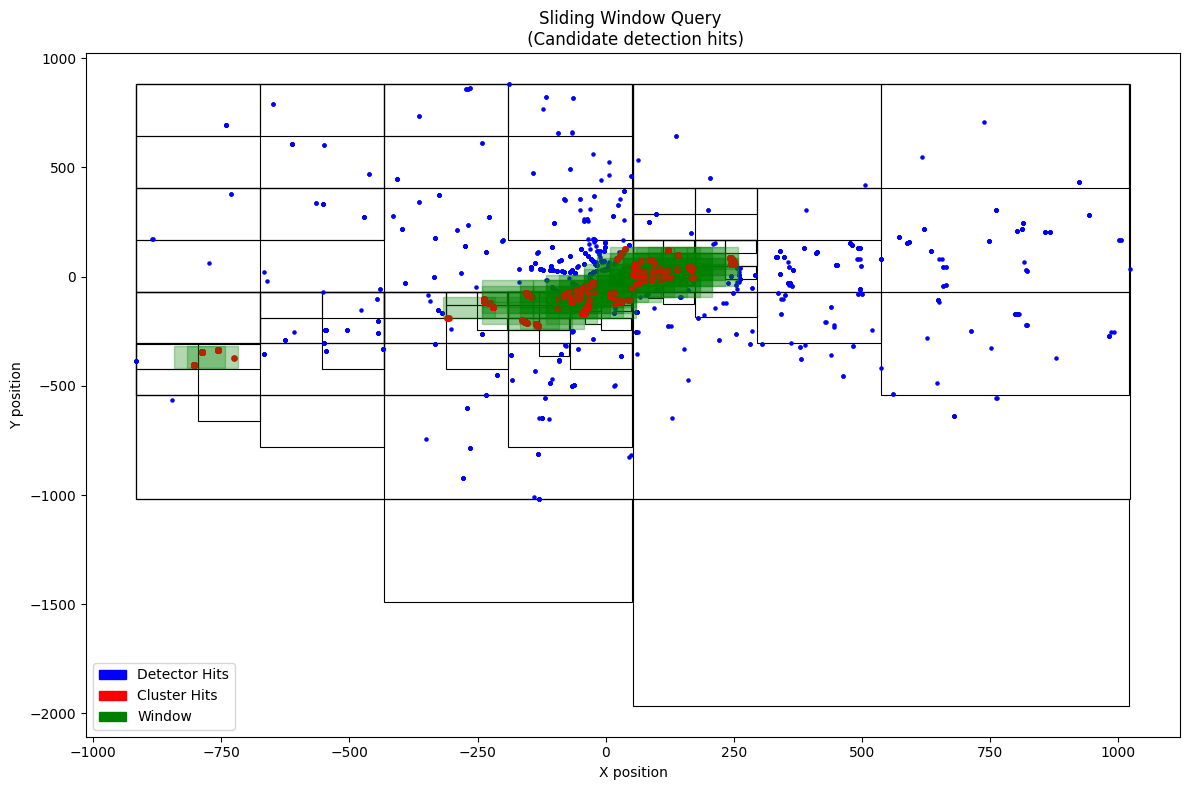

In [13]:
from src.visualization import visualize_windows_results
visualize_windows_results(quadtree, points, query_result)

## Analyzing the clusters
----

In [14]:
clusters = []
for window, count, cluster_hits in query_result:
    cluster = {
        'coordinates': (window.x, window.y),
        'particles_count': count,
        'avg_particle_charge': np.mean([point.metadata['q'] for point in cluster_hits]),
        'particles': [point.metadata for point in cluster_hits]
    }
    clusters.append(cluster)

display(pd.DataFrame(clusters))

,coordinates,particles_count,avg_particle_charge,particles
0,"(-841.693, -416.22)",20,1.000000,"[{'x': -788.559, 'y': -343.583, 'q': 1.0, 'par..."
1,"(-816.693, -416.22)",21,0.904762,"[{'x': -788.559, 'y': -343.583, 'q': 1.0, 'par..."
2,"(-316.693, -191.22000000000003)",21,1.000000,"[{'x': -238.612, 'y': -112.118, 'q': 1.0, 'par..."
3,"(-241.69299999999998, -216.22000000000003)",20,0.900000,"[{'x': -158.132, 'y': -207.819, 'q': 1.0, 'par..."
4,"(-241.69299999999998, -191.22000000000003)",24,1.000000,"[{'x': -238.612, 'y': -112.118, 'q': 1.0, 'par..."
...,...,...,...,...
82,"(133.30700000000002, 33.77999999999997)",24,0.416667,"[{'x': 167.936, 'y': 35.3211, 'q': -1.0, 'part..."
83,"(158.30700000000002, -41.22000000000003)",28,0.500000,"[{'x': 167.936, 'y': 35.3211, 'q': -1.0, 'part..."
84,"(158.30700000000002, -16.220000000000027)",33,0.393939,"[{'x': 167.936, 'y': 35.3211, 'q': -1.0, 'part..."
85,"(158.30700000000002, 8.779999999999973)",36,0.500000,"[{'x': 167.936, 'y': 35.3211, 'q': -1.0, 'part..."
